In [1]:
import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from matplotlib import collections
import os
from shutil import rmtree
from IPython.display import Video
plt.rcParams.update({'font.size': 12, 'pdf.fonttype':42,'text.usetex': False, 'font.family': 'serif'})

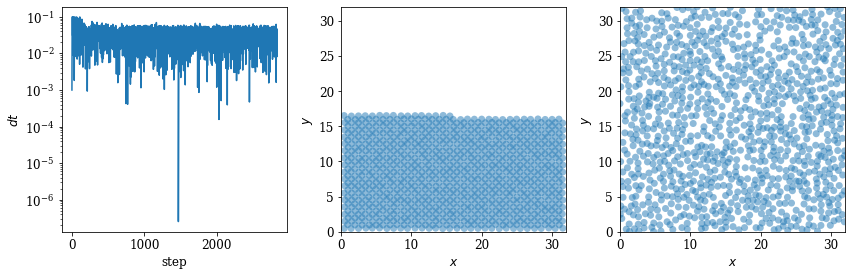

In [54]:
filebase='data/lattice'
file=open(filebase+'.out')
N,dim,L,R=file.readline().split()
N=int(N)
dim=int(dim)
L=float(L)
R=float(R)
file.close()
times=np.fromfile(filebase+'times.dat')
states=np.fromfile(filebase+'states.dat')
states=states.reshape((int(len(states)/((2*dim)*N)),(2*dim)*N))

plt.subplots(1,3,figsize=(12,4))
plt.subplot(1,3,1)
plt.ylabel('$dt$')
plt.xlabel('step')
plt.yscale('log')
plt.plot(np.diff(times))
plt.subplot(1,3,2)
circles = [plt.Circle((x,y), radius=R) for (x,y) in zip(states[0,0::4],states[0,1::4])]
plt.gca().add_collection(collections.PatchCollection(circles,alpha=0.5))
plt.xlim(0,L)
plt.ylim(0,L)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.gca().set_aspect(1)
plt.subplot(1,3,3)
circles = [plt.Circle((x,y), radius=R) for (x,y) in zip(states[-1,0::4],states[-1,1::4])]
plt.gca().add_collection(collections.PatchCollection(circles,alpha=0.5))
plt.xlim(0,L)
plt.ylim(0,L)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.gca().set_aspect(1)

plt.tight_layout()
plt.show()

In [55]:
skip=1
if os.path.isdir(filebase+'animation'):
    rmtree(filebase+'animation')
if not os.path.isdir(filebase+'animation'):
    os.mkdir(filebase+'animation')
    
for i in range(int(len(states)/skip)):
    print(i, int(len(states)/skip),end='\r')
    circles = [plt.Circle((x,y), radius=R) for (x,y) in zip(states[skip*i,0::4],states[skip*i,1::4])]
    plt.gca().add_collection(collections.PatchCollection(circles,alpha=0.5))
    plt.xlim(0,L)
    plt.ylim(0,L)
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.gca().set_aspect(1)
    plt.savefig(filebase+'animation/'+str(i).zfill(4)+'.png', dpi=100,bbox_inches='tight')
    plt.close('all')
    
os.system('./encode.sh ' + filebase+'animation/' + ' '  + filebase+'animation 15 ')

0

In [4]:
filebase='data/loose'
Video(filebase+'animation.mp4',width=512)

In [7]:
filebase='data/tight'
Video(filebase+'animation.mp4',width=512)

In [56]:
filebase='data/lattice'
Video(filebase+'animation.mp4',width=512)

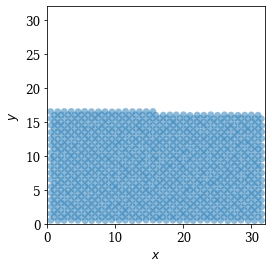

In [53]:
N=1024
xs=[]
ys=[]
x=R
y=R
for i in range(N):
    xs.append(x+0.1*(np.random.random()-0.5))
    ys.append(y+0.1*(np.random.random()-0.5))
    x=x+2*R
    if(x>L-R):
        y=y+R
        x=x-L+R
circles = [plt.Circle((x,y), radius=R) for (x,y) in zip(ic[0::4],ic[1::4])]
plt.gca().add_collection(collections.PatchCollection(circles,alpha=0.5))
plt.xlim(0,L)
plt.ylim(0,L)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.gca().set_aspect(1)

ic=np.concatenate(np.array([xs,ys,0*(np.random.random(N)-0.5),0*(np.random.random(N)-0.5)]).T)
ic.tofile('data/latticeic.dat')